Взять CIFAR100 и обучить resnet18 с нуля на нем

Определить легкие и тяжелые объекты по лоссам итоговой модели

Взять другую модель и обучить её для CIFAR100  двумя способами:

1)объекты в рандомном порядке n эпох

2)чем больше номер эпохи чем больше вероятность выбрать сложный объект 

(да,распределение на индексах:вероятность выбрать объект сначала тем меньше,тем он сложнее,по ходу обучения распределение выходит на равномерное)

#1
Load vgg16_bn model pretrained on CIFAR100 and get losses for train_data with it

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms,datasets
from torchvision.models import resnet18
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt


from tqdm import tqdm

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

num_classes = 53
model_for_weights = resnet18(weights='DEFAULT')
model_for_weights.fc = nn.Linear(512,num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [2]:
data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)
transformation = transforms.Compose([
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.3),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, .25, 0.25])
])

full_dataset = datasets.ImageFolder(
    root='/notebooks/train',
    transform=transformation
)
train_len = int(len(full_dataset)*0.8)
test_len = len(full_dataset) - train_len
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset,[train_len,test_len])

print(len(train_dataset))

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 10
device

6099


'cuda'

In [3]:
from tqdm import tqdm
optimizer = torch.optim.Adam(model_for_weights.parameters(),lr=5e-4)
model_for_weights = model_for_weights.to(device)
loss_function = nn.CrossEntropyLoss()

for i in range(n_epochs):
  model_for_weights.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_for_weights(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_for_weights.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      logits = model_for_weights(x)
      preds = logits.max(dim=1)[1]
      val_acc += torch.mean((preds == y).float())
      loss = loss_function(logits,y)
      val_loss += loss    

  
  train_len = len(train_loader)
  val_len = len(test_loader)
  
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len } val acc:{val_acc / val_len }')

100%|██████████| 48/48 [00:05<00:00,  9.35it/s]


epoch 0: train loss:2.0740137100219727 val loss:1.4044101238250732 val acc:0.6128472089767456


100%|██████████| 48/48 [00:01<00:00, 33.18it/s]


epoch 1: train loss:1.1016823053359985 val loss:1.0904648303985596 val acc:0.7023190259933472


100%|██████████| 48/48 [00:01<00:00, 32.06it/s]


epoch 2: train loss:0.7484479546546936 val loss:0.9982576370239258 val acc:0.7115575671195984


100%|██████████| 48/48 [00:01<00:00, 29.94it/s]


epoch 3: train loss:0.5439008474349976 val loss:0.9811404943466187 val acc:0.7381882667541504


100%|██████████| 48/48 [00:01<00:00, 31.42it/s]


epoch 4: train loss:0.37449443340301514 val loss:1.054944396018982 val acc:0.748604953289032


100%|██████████| 48/48 [00:01<00:00, 31.37it/s]


epoch 5: train loss:0.2938919961452484 val loss:1.0573453903198242 val acc:0.7561074495315552


100%|██████████| 48/48 [00:01<00:00, 31.85it/s]


epoch 6: train loss:0.23418578505516052 val loss:1.0940985679626465 val acc:0.7576885223388672


100%|██████████| 48/48 [00:01<00:00, 31.51it/s]


epoch 7: train loss:0.21198393404483795 val loss:1.1557509899139404 val acc:0.7639509439468384


100%|██████████| 48/48 [00:01<00:00, 30.87it/s]


epoch 8: train loss:0.16362732648849487 val loss:1.075825572013855 val acc:0.7704613208770752


100%|██████████| 48/48 [00:01<00:00, 31.83it/s]

epoch 9: train loss:0.13248519599437714 val loss:1.1193825006484985 val acc:0.7645399570465088


In [4]:
def prepare_transforms(augments=[True, False]):
    data_mean = (0.5071, 0.4865, 0.4409)
    data_std = (0.2673, 0.2564, 0.2762)
    # types of transform: with augmentation and without
    transform_augmented = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    transform_clean = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    # choose transform according func params
    train_transform = transform_augmented if augments[0] else transform_clean
    test_transform = transform_augmented if augments[1] else transform_clean

    return train_transform, test_transform

In [5]:
def get_loaders(batch_size=32, augments=[True, False], shuffles=[True, False]):
    full_dataset = datasets.ImageFolder(
        root='/notebooks/train',
        transform=transformation
    )
    train_len = int(len(full_dataset)*0.8)
    test_len = len(full_dataset) - train_len
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset,[train_len,test_len])
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffles[0],
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)

    return train_loader, test_loader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
train_loader,test_loader = get_loaders(shuffles=[False,False])

In [8]:
model_for_weights = model_for_weights.to(device)

In [9]:
# num_classes = 100

class_count = dict(zip(range(num_classes),[0]*(num_classes)))
for _,y in tqdm(test_loader):
    for label in y:
        class_count[label.item()] += 1

# class_count

class_acc = dict(zip(range((num_classes)),[0]*(num_classes)))

for x,y in tqdm(test_loader):
    x,y = x.to(device), y.to(device)
    logits = model_for_weights(x)
    preds = logits.max(1)[1]
    for (predicted,target) in zip(preds,y):
      if predicted == target:
        class_acc[target.item()] += 1

for key in class_acc.keys():
  class_acc[key] /= class_count[key]

sorted_by_acc = sorted(class_acc.items(),key=lambda x:x[1])
print(sorted_by_acc)

100%|██████████| 48/48 [00:00<00:00, 52.89it/s]

[(5, 0.6153846153846154), (21, 0.7), (38, 0.7666666666666667), (31, 0.7837837837837838), (29, 0.7857142857142857), (14, 0.8518518518518519), (17, 0.8571428571428571), (48, 0.8571428571428571), (7, 0.875), (47, 0.88), (40, 0.8823529411764706), (4, 0.9), (45, 0.9090909090909091), (33, 0.9130434782608695), (49, 0.9130434782608695), (1, 0.9166666666666666), (16, 0.918918918918919), (51, 0.918918918918919), (22, 0.92), (23, 0.9310344827586207), (19, 0.9428571428571428), (42, 0.9428571428571428), (9, 0.9523809523809523), (50, 0.9565217391304348), (46, 0.9583333333333334), (26, 0.96), (8, 0.9666666666666667), (44, 0.967741935483871), (25, 0.96875), (35, 0.9696969696969697), (18, 0.9705882352941176), (30, 0.9714285714285714), (32, 0.9714285714285714), (41, 0.9736842105263158), (36, 0.975), (3, 0.975609756097561), (11, 0.9777777777777777), (0, 1.0), (2, 1.0), (6, 1.0), (10, 1.0), (12, 1.0), (13, 1.0), (15, 1.0), (20, 1.0), (24, 1.0), (27, 1.0), (28, 1.0), (34, 1.0), (37, 1.0), (39, 1.0), (43, 1

In [10]:
acc_on_sample_class = []
with torch.no_grad():
  for x,y in  tqdm(train_loader):
      for label in y:
            acc_on_sample_class.append(class_acc[label.item()])

# np.unique(acc_on_sample_class,return_counts=True)
acc_on_sample_class = np.array(acc_on_sample_class)

100%|██████████| 191/191 [00:03<00:00, 58.05it/s]


Make dict to save loss history on test_data for different curriclum modes

In [11]:
losses_train_history = {'random':[],'hard first':[],'easy first':[],'mixed':[]}
losses_val_history = {'random':[],'hard first':[],'easy first':[],'mixed':[]}
acc_val_history = {'random':[],'hard first':[],'easy first':[],'mixed':[]}

1)Random

In [12]:
from torchvision.models import resnet18

model = resnet18(weights='DEFAULT')
model.fc = nn.Linear(512,num_classes)

In [13]:
train_loader,test_loader = get_loaders()

In [14]:
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
loss_function = nn.CrossEntropyLoss()
model.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [15]:
for x,y in train_loader:
  print(x.shape,y.shape)
  break

x = x.to(device)
output = model(x)
print(output.shape)

y = y.to(device)
loss = loss_function(output,y)
loss

torch.Size([32, 3, 64, 64]) torch.Size([32])
torch.Size([32, 53])


tensor(4.3978, device='cuda:0', grad_fn=<NllLossBackward0>)

In [16]:
# n_epochs = N_EPOCHS

for i in range(n_epochs):
  model.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      logits = model(x)
      preds = logits.max(dim=1)[1]
      val_acc += torch.mean((preds == y).float())
      loss = loss_function(logits,y)
      val_loss += loss    

  
  train_len = len(train_loader)
  val_len = len(test_loader)
  
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len } val acc:{val_acc / val_len }')

  losses_train_history['random'].append(train_loss / train_len)
  losses_val_history['random'].append(val_loss / val_len)
  acc_val_history['random'].append(val_acc / val_len)

100%|██████████| 48/48 [00:01<00:00, 41.43it/s]


epoch 0: train loss:2.0339808464050293 val loss:1.3545608520507812 val acc:0.6254960298538208


100%|██████████| 48/48 [00:01<00:00, 47.48it/s]


epoch 1: train loss:1.0662600994110107 val loss:1.0974488258361816 val acc:0.6906312704086304


100%|██████████| 48/48 [00:01<00:00, 47.82it/s]


epoch 2: train loss:0.7473480701446533 val loss:1.0336490869522095 val acc:0.7202691435813904


100%|██████████| 48/48 [00:00<00:00, 51.01it/s]


epoch 3: train loss:0.5262752175331116 val loss:0.9961415529251099 val acc:0.7297247648239136


100%|██████████| 48/48 [00:01<00:00, 46.84it/s]


epoch 4: train loss:0.4011530876159668 val loss:0.9803200960159302 val acc:0.7541543245315552


100%|██████████| 48/48 [00:00<00:00, 48.39it/s]


epoch 5: train loss:0.28006571531295776 val loss:1.0669375658035278 val acc:0.760664701461792


100%|██████████| 48/48 [00:01<00:00, 46.59it/s]


epoch 6: train loss:0.25003916025161743 val loss:1.1314003467559814 val acc:0.7346230745315552


100%|██████████| 48/48 [00:01<00:00, 46.93it/s]


epoch 7: train loss:0.21143142879009247 val loss:1.115282416343689 val acc:0.7613157629966736


100%|██████████| 48/48 [00:00<00:00, 48.55it/s]


epoch 8: train loss:0.1503748744726181 val loss:1.0490808486938477 val acc:0.7649120092391968


100%|██████████| 48/48 [00:00<00:00, 49.01it/s]

epoch 9: train loss:0.13026612997055054 val loss:1.0120179653167725 val acc:0.7724144458770752


In [17]:
def get_loaders_weighted(weights,data_dir='cifar-100', batch_size=32, augments=[True, False], shuffles=[False, False]):
    full_dataset = datasets.ImageFolder(
        root='/notebooks/train',
        transform=transformation
    )
    train_len = int(len(full_dataset)*0.8)
    test_len = len(full_dataset) - train_len
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset,[train_len,test_len])

    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights),replacement=False)                     
 
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, sampler = sampler,
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)
    
    return train_loader, test_loader

2)hard first

In [18]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,num_classes)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=5e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [19]:

for i in range(n_epochs):
  if i < n_epochs//2:
    weights =  (1+acc_on_sample_class) ** (-2)
  else:
    weigths = np.array([1]*len(acc_on_sample_class))
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      logits = model_transfer(x)
      preds = logits.max(dim=1)[1]
      val_acc += torch.mean((preds == y).float())
      loss = loss_function(logits,y)
      val_loss += loss    

  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }  val acc:{val_acc / val_len }')

  losses_train_history['hard first'].append(train_loss / train_len)
  losses_val_history['hard first'].append(val_loss / val_len)
  acc_val_history['hard first'].append(val_acc / val_len)

100%|██████████| 48/48 [00:00<00:00, 48.75it/s]


epoch 0: train loss:2.068578004837036 val loss:1.368167757987976  val acc:0.6121962070465088


100%|██████████| 48/48 [00:00<00:00, 49.05it/s]


epoch 1: train loss:1.1015299558639526 val loss:0.9314953088760376  val acc:0.7254464626312256


100%|██████████| 48/48 [00:00<00:00, 49.76it/s]


epoch 2: train loss:0.8229163289070129 val loss:0.7647766470909119  val acc:0.7756696939468384


100%|██████████| 48/48 [00:01<00:00, 47.07it/s]


epoch 3: train loss:0.6200888156890869 val loss:0.5969280004501343  val acc:0.8202505111694336


100%|██████████| 48/48 [00:01<00:00, 44.45it/s]


epoch 4: train loss:0.47879356145858765 val loss:0.5152740478515625  val acc:0.8508495092391968


100%|██████████| 48/48 [00:01<00:00, 47.83it/s]


epoch 5: train loss:0.3937220871448517 val loss:0.479745477437973  val acc:0.8593440055847168


100%|██████████| 48/48 [00:00<00:00, 49.36it/s]


epoch 6: train loss:0.3274715840816498 val loss:0.3235640823841095  val acc:0.8983445167541504


100%|██████████| 48/48 [00:01<00:00, 45.76it/s]


epoch 7: train loss:0.24310079216957092 val loss:0.20918600261211395  val acc:0.93325275182724


100%|██████████| 48/48 [00:01<00:00, 44.78it/s]


epoch 8: train loss:0.22952257096767426 val loss:0.23312881588935852  val acc:0.92934650182724


100%|██████████| 48/48 [00:00<00:00, 50.87it/s]

epoch 9: train loss:0.20452341437339783 val loss:0.19895318150520325  val acc:0.9387401342391968


3)easy first

In [20]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,num_classes)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=5e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [21]:
for i in range(n_epochs):
  if i < n_epochs//2:
    weights =  (1+acc_on_sample_class) ** (2)
  else:
    weigths = np.array([1]*len(acc_on_sample_class))
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      logits = model_transfer(x)
      preds = logits.max(dim=1)[1]
      val_acc += torch.mean((preds == y).float())
      loss = loss_function(logits,y)
      val_loss += loss    

  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }  val acc:{val_acc / val_len }')

  losses_train_history['easy first'].append(train_loss / train_len)
  losses_val_history['easy first'].append(val_loss / val_len)
  acc_val_history['easy first'].append(val_acc / val_len)

100%|██████████| 48/48 [00:01<00:00, 44.45it/s]


epoch 0: train loss:2.0713953971862793 val loss:1.5729987621307373  val acc:0.5776599645614624


100%|██████████| 48/48 [00:01<00:00, 47.27it/s]


epoch 1: train loss:1.0924783945083618 val loss:0.986974835395813  val acc:0.717354953289032


100%|██████████| 48/48 [00:01<00:00, 47.22it/s]


epoch 2: train loss:0.7871131896972656 val loss:0.8027693629264832  val acc:0.76298987865448


100%|██████████| 48/48 [00:00<00:00, 49.08it/s]


epoch 3: train loss:0.6309688687324524 val loss:0.5810555219650269  val acc:0.8293651342391968


100%|██████████| 48/48 [00:01<00:00, 47.78it/s]


epoch 4: train loss:0.4465095102787018 val loss:0.4491668939590454  val acc:0.8701016902923584


100%|██████████| 48/48 [00:00<00:00, 50.30it/s]


epoch 5: train loss:0.3599247634410858 val loss:0.4172102212905884  val acc:0.8745970129966736


100%|██████████| 48/48 [00:00<00:00, 48.39it/s]


epoch 6: train loss:0.28964537382125854 val loss:0.27055245637893677  val acc:0.9237971305847168


100%|██████████| 48/48 [00:00<00:00, 50.82it/s]


epoch 7: train loss:0.24568980932235718 val loss:0.24416504800319672  val acc:0.9342138171195984


100%|██████████| 48/48 [00:00<00:00, 49.05it/s]


epoch 8: train loss:0.20758549869060516 val loss:0.19470016658306122  val acc:0.9374690055847168


100%|██████████| 48/48 [00:00<00:00, 51.02it/s]

epoch 9: train loss:0.2071676254272461 val loss:0.23276309669017792  val acc:0.9267423152923584


In [22]:
def tensor_list_to_list(list_of_tensors):
  return [t.item() for t in list_of_tensors]

4)mixed

In [23]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,num_classes)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=5e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [24]:

for i in range(n_epochs):
  weights = 1. / ( acc_on_sample_class + 1.0)**((n_epochs//2 - i) / 10)
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      logits = model_transfer(x)
      preds = logits.max(dim=1)[1]
      val_acc += torch.mean((preds == y).float())
      loss = loss_function(logits,y)
      val_loss += loss    

  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }  val acc:{val_acc / val_len }')

  losses_train_history['mixed'].append(train_loss / train_len)
  losses_val_history['mixed'].append(val_loss / val_len)
  acc_val_history['mixed'].append(val_acc / val_len)

100%|██████████| 48/48 [00:01<00:00, 46.64it/s]


epoch 0: train loss:2.081382989883423 val loss:1.4255380630493164  val acc:0.5984933376312256


100%|██████████| 48/48 [00:00<00:00, 48.82it/s]


epoch 1: train loss:1.2038837671279907 val loss:0.9826819896697998  val acc:0.7229043245315552


100%|██████████| 48/48 [00:00<00:00, 48.48it/s]


epoch 2: train loss:0.8537231683731079 val loss:0.8664390444755554  val acc:0.7356151342391968


100%|██████████| 48/48 [00:00<00:00, 48.04it/s]


epoch 3: train loss:0.6580421328544617 val loss:0.6479876637458801  val acc:0.8108259439468384


100%|██████████| 48/48 [00:01<00:00, 44.64it/s]


epoch 4: train loss:0.5095081329345703 val loss:0.5337403416633606  val acc:0.8289930820465088


100%|██████████| 48/48 [00:00<00:00, 48.08it/s]


epoch 5: train loss:0.40600910782814026 val loss:0.41473454236984253  val acc:0.8746280074119568


100%|██████████| 48/48 [00:01<00:00, 46.31it/s]


epoch 6: train loss:0.2994728982448578 val loss:0.2909367084503174  val acc:0.9081721305847168


100%|██████████| 48/48 [00:01<00:00, 47.46it/s]


epoch 7: train loss:0.27273881435394287 val loss:0.2806590795516968  val acc:0.90786212682724


100%|██████████| 48/48 [00:00<00:00, 51.01it/s]


epoch 8: train loss:0.24368543922901154 val loss:0.16808682680130005  val acc:0.9495288133621216


100%|██████████| 48/48 [00:00<00:00, 48.61it/s]

epoch 9: train loss:0.1927078813314438 val loss:0.19011321663856506  val acc:0.94921875


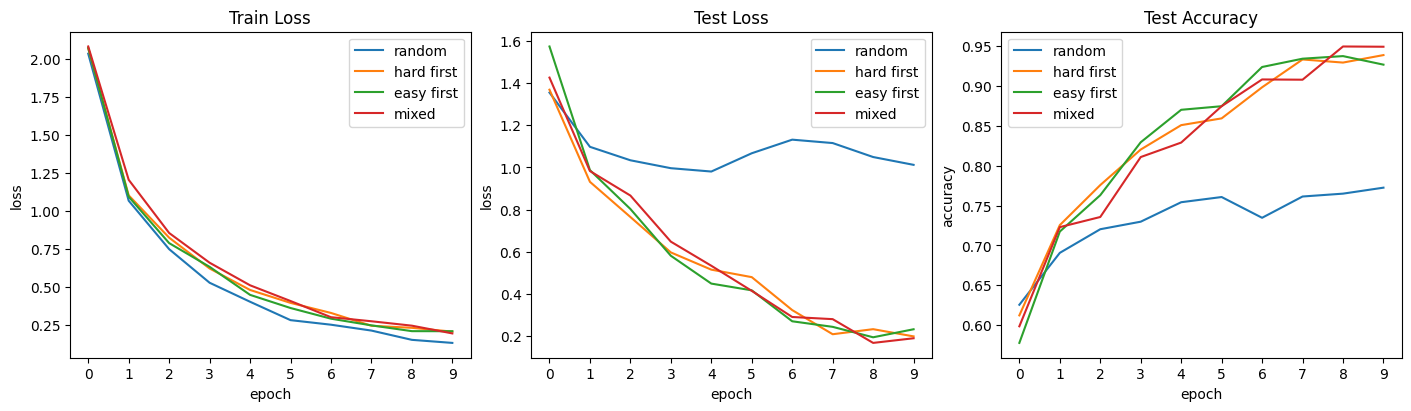

In [25]:
def tensor_to_list(t):
    return [el.item() for el in t][:12]

fig,axes = plt.subplots(1,3,figsize=(14,4),constrained_layout=True)

for mode in acc_val_history.keys():
    axes[2].plot(range(n_epochs), tensor_to_list(acc_val_history[mode]),label=mode)
    axes[2].legend()
    axes[2].set_xticks(range(n_epochs))

axes[2].set_title('Test Accuracy')


for mode in losses_val_history.keys():
    axes[1].plot(range(n_epochs), tensor_to_list(losses_val_history[mode]),label=mode)

axes[1].set_title('Test Loss')
axes[1].legend()
axes[1].set_xticks(range(n_epochs))

for index,ax in enumerate(axes):
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss' if index < 2 else 'accuracy')

for mode in losses_train_history.keys():
    axes[0].plot(range(n_epochs), tensor_to_list(losses_train_history[mode]),label=mode)

axes[0].set_title('Train Loss')
axes[0].legend()
axes[0].set_xticks(range(n_epochs))

plt.savefig('cifar100_tr_cl_metrics.png')


6099


ValueError: x and y must have same first dimension, but have shapes (50000,) and (6099,)

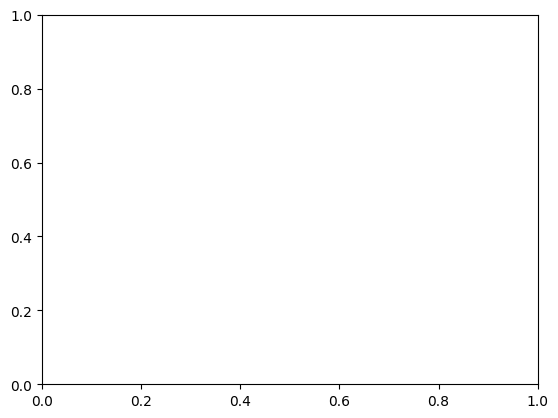

In [28]:
num_samples = 60
print(len(acc_on_sample_class))
on_curr_weights = 1. / (acc_on_sample_class + 1.0)**(2) 
anti_curr_weights = 1. / (acc_on_sample_class + 1.0)**(-2) 
plt.plot(range(num_samples),on_curr_weights,label='on-curriculum',c='green')
plt.plot(range(num_samples),anti_curr_weights,label='anti-curriculum')
plt.xlabel('sample index')
plt.ylabel('weight')
plt.legend()
plt.savefig('sample weights.png')